### Importing the Libraries

In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

## Loading the data

Defining a function to load the data in sorted order

In [9]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

* First we will load the filenames in a list.  
* Then we will open each filename as an Image and convert it to numpy array and create list of such numpy arrays.
* Same will be done for both Feature Images and Label Images

In [10]:
filelist_trainx_ph2 = sorted(glob.glob('ph2_resized/trainx/*.bmp'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('ph2_resized/trainy/*.bmp'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

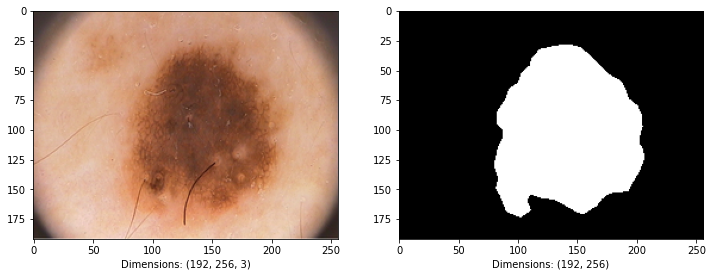

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()

We can observe that the images are of dimensions **(572, 765)** so we will scale dow the images. It will also reduce the training time of the network.

#### Resizing

In [12]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [13]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))    

Let us check the new images

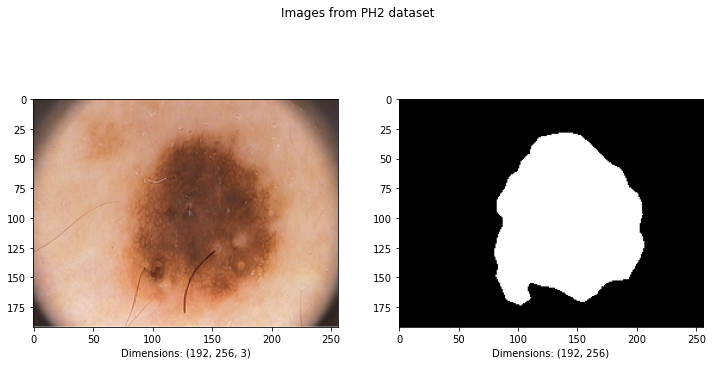

In [14]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from PH2 dataset")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2_resized[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2_resized[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2_resized[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2_resized[0]).shape))
plt.show()

Converting the transformed Images into numpy arrays

In [15]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

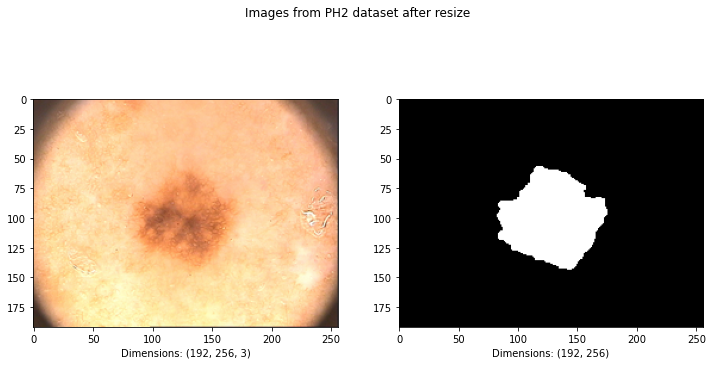

In [16]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from PH2 dataset after resize")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[123])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2_resized[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[123], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2_resized[0]).shape))
plt.show()

Splitting the dataset into training set and test set to verify our model performance without any bias.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

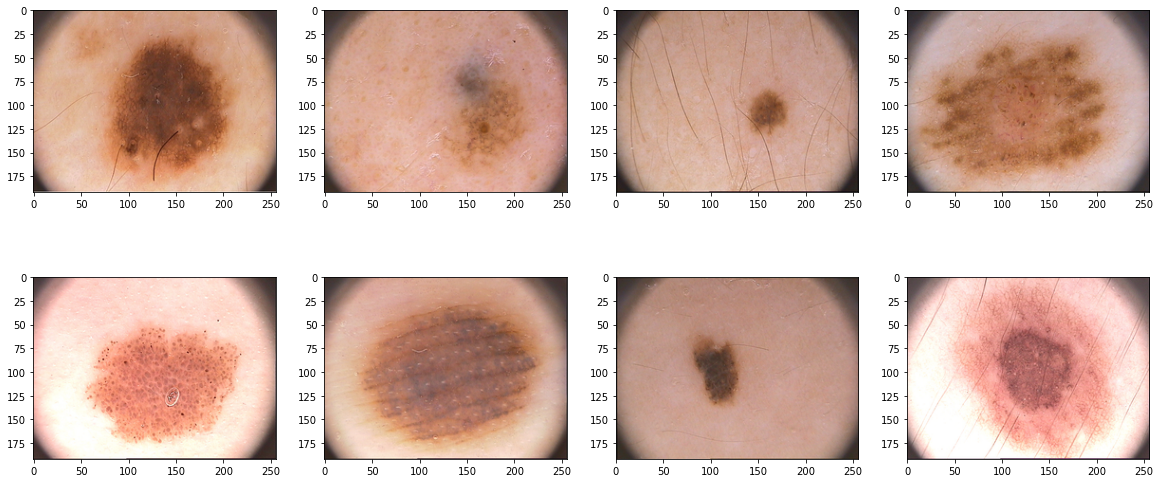

In [18]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train_ph2[0])
plt.subplot(2,4,2)
plt.imshow(X_train_ph2[3])
plt.subplot(2,4,3)
plt.imshow(X_train_ph2[54])
plt.subplot(2,4,4)
plt.imshow(X_train_ph2[77])
plt.subplot(2,4,5)
plt.imshow(X_train_ph2[100])
plt.subplot(2,4,6)
plt.imshow(X_train_ph2[125])
plt.subplot(2,4,7)
plt.imshow(X_train_ph2[130])
plt.subplot(2,4,8)
plt.imshow(X_train_ph2[149])
plt.show()

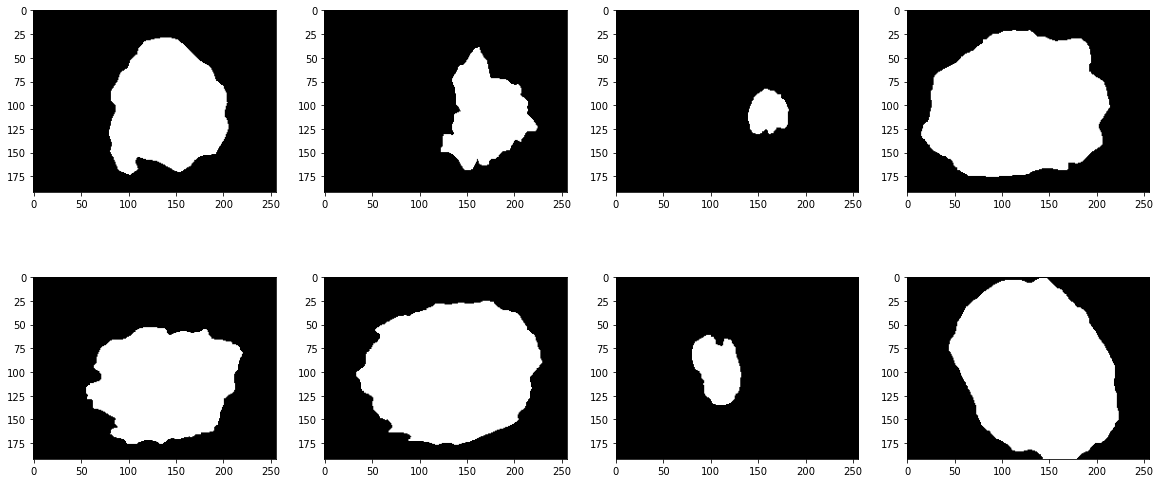

In [19]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train_ph2[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train_ph2[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train_ph2[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train_ph2[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train_ph2[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train_ph2[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train_ph2[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train_ph2[149], cmap = plt.cm.binary_r)
plt.show()

## Defining Evaluation Metrics

#### Intersection over Union
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![i](https://www.d2l.ai/_images/iou.svg)

In [20]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Dice Coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![i](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [21]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Precision
Precision is a good measure to determine, when the costs of False Positive is high

![i](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [22]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Recall
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative

![i](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [23]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Accuracy

In [24]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image Augmentation

To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [25]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [26]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [27]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

Let us have a look at our transformations.

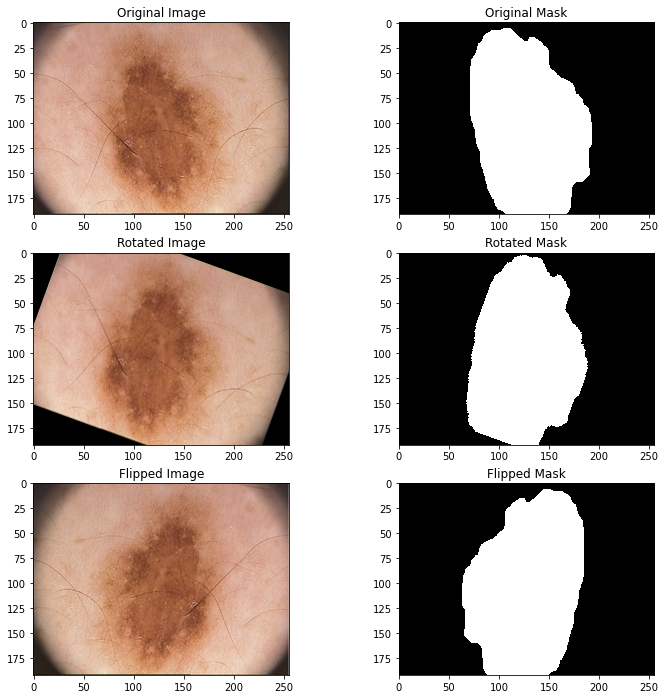

In [28]:
img_num = 112
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [29]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#### Making a Validation Set

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [31]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


We will split our full training set into train and validation set.  
Validation dataset is used to validate the performance after each epoch

## The Model

Defining the model in a function which takes two arguments when called


* **epoch_num**: number of epochs to run  
* **savename**: the name of the model for saving after training  

Optimizer and Learning Rate  
* We adopt SGD optimization algorithm, to adjust the learning rate.
* It is well known that learning rate is one of the critical hyperparameters that have a signiﬁcant impact on classiﬁcation performance.
* On large datasets, SGD can converge faster than batch training because it performs updates more frequently. We can get away with this because the data often contains redundant information, so the gradient can be reasonably approximated without using the full dataset. Minibatch training can be faster than training on single data points because it can take advantage of vectorized operations to process the entire minibatch at once. The stochastic nature of online/minibatch training can also make it possible to hop out of local minima that might otherwise trap batch training.
* The learning rate is the conventional 0.001.

#### Model Function

![ii](graphics/seg_net.png)

* The above network is a variation of the architecture proposed [here](https://arxiv.org/pdf/1511.00561.pdf), we have customised it for our problem of lesion segmentation.
* The advised parameters can't exactly be applied to our problem.
* We will switch the final activation function from **Softmax** to **Sigmoid** as using softmax was producing blank dark images.
* The loss function in segnet is suggested **categorical crossentropy** due to it's genral use of multiclass segmentation problem but in our case we only have 1 class i.e. the melanoma. So, we will use **binary crossentropy**.

In [32]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(learning_rate= 0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

#### After 1 epoch

In [ ]:
model, hist = segnet(1, 'segnet_1_epoch.h5')

### Loading the Model

Here we can load a pre-trained model

In [33]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)


In [34]:
model_0 = Model(inputs=img_input, outputs=pred)

model_0.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [35]:
model_0.load_weights('segnet_1_epoch.h5')

In [37]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 137s 7s/step - loss: 0.6865 - iou: 0.6807 - dice_coef: 0.3847 - precision: 0.0492 - recall: 0.0019 - accuracy: 0.6647
________________________
IOU:       |   68.07  |
Dice Coef: |   38.47  |
Precision: |   4.92  |
Recall:    |   0.19  |
Accuracy:  |   66.47  |
Loss:      |   68.65  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 19s 6s/step - loss: 4.3739 - iou: 0.1846 - dice_coef: 0.9708 - precision: 24.0393 - recall: 1.0000 - accuracy: 0.6716
________________________
IOU:       |   18.46  |
Dice Coef: |   97.08  |
Precision: |   2403.93  |
Recall:    |   100.00  |
Accuracy:  |   67.16  |
Loss:      |   437.39  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 35s 7s/step - loss: 0.6860 - iou: 0.67

#### After 100 epochs

In [39]:
model, hist = segnet(epochs_num= 100, savename= 'segnet_100_epoch.h5')

20/20 [==============================] - 521s 27s/step - loss: 0.1396 - iou: 0.9597 - dice_coef: 0.8305 - precision: 0.9494 - recall: 0.9571 - accuracy: 0.9698 - val_loss: 0.1625 - val_iou: 0.9498 - val_dice_coef: 0.8163 - val_precision: 0.9232 - val_recall: 0.9334 - val_accuracy: 0.9547
Epoch 91/100
20/20 [==============================] - 673s 34s/step - loss: 0.1346 - iou: 0.9622 - dice_coef: 0.8352 - precision: 0.9546 - recall: 0.9594 - accuracy: 0.9719 - val_loss: 0.1635 - val_iou: 0.9495 - val_dice_coef: 0.8148 - val_precision: 0.9234 - val_recall: 0.9312 - val_accuracy: 0.9539
Epoch 92/100
20/20 [==============================] - 793s 40s/step - loss: 0.1314 - iou: 0.9636 - dice_coef: 0.8391 - precision: 0.9536 - recall: 0.9645 - accuracy: 0.9732 - val_loss: 0.1636 - val_iou: 0.9495 - val_dice_coef: 0.8152 - val_precision: 0.9206 - val_recall: 0.9347 - val_accuracy: 0.9540
Epoch 93/100
20/20 [==============================] - 757s 38s/step - loss: 0.1297 - iou: 0.9640 - dice_coe

In [40]:
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [41]:
model_1.load_weights('segnet_100_epoch.h5')

In [42]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 106s 5s/step - loss: 0.1160 - iou: 0.9699 - dice_coef: 0.8508 - precision: 0.9551 - recall: 0.9782 - accuracy: 0.9787
________________________
IOU:       |   96.99  |
Dice Coef: |   85.08  |
Precision: |   95.51  |
Recall:    |   97.82  |
Accuracy:  |   97.87  |
Loss:      |   11.60  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 18s 6s/step - loss: -178.0246 - iou: 0.2855 - dice_coef: 1.7263 - precision: 0.9232 - recall: 1.0000 - accuracy: 0.6381
________________________
IOU:       |   28.55  |
Dice Coef: |   172.63  |
Precision: |   92.32  |
Recall:    |   100.00  |
Accuracy:  |   63.81  |
Loss:      |   -17802.46  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 37s 8s/step - loss: 0.1638 - i

### Plotting Training Statistics

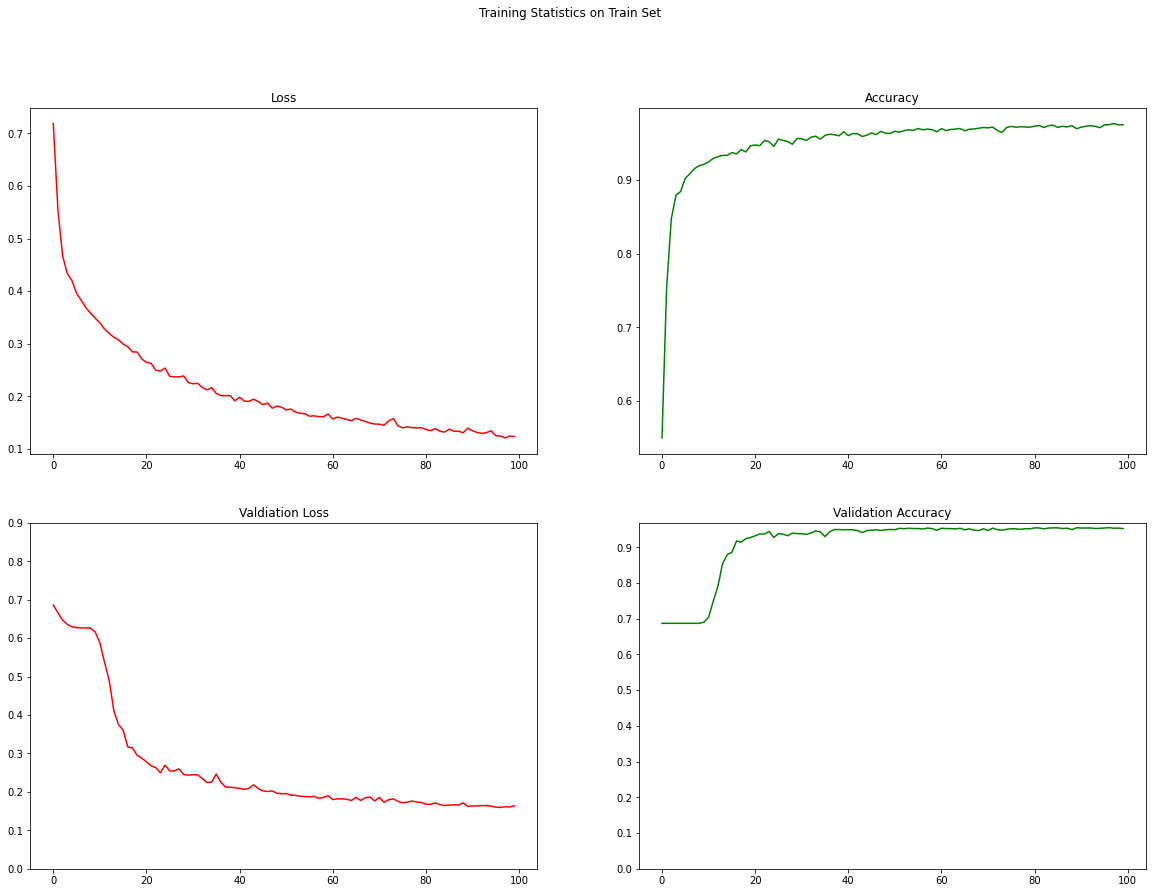

In [43]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

### Visualising Predicted Lesions

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

1/1 [==============================] - 1s 1s/step


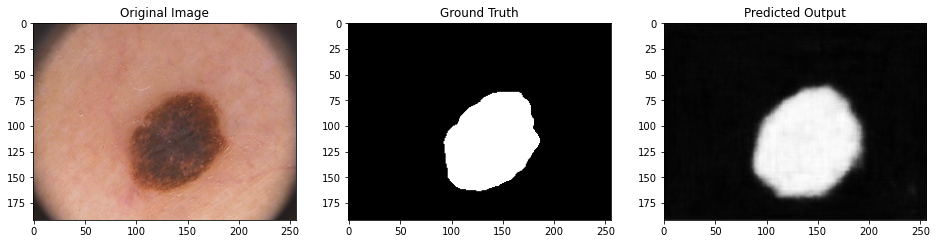

In [44]:
img_num = 49
img_pred = model_0.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 1s 1s/step


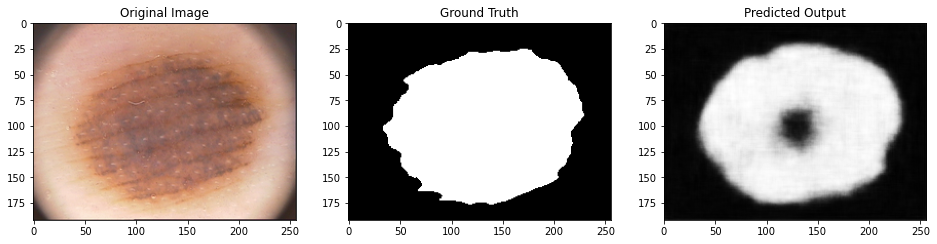

In [45]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 410ms/step


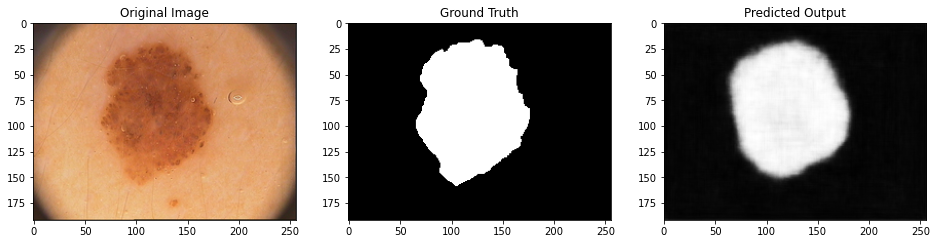

In [46]:
img_num = 32
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 436ms/step


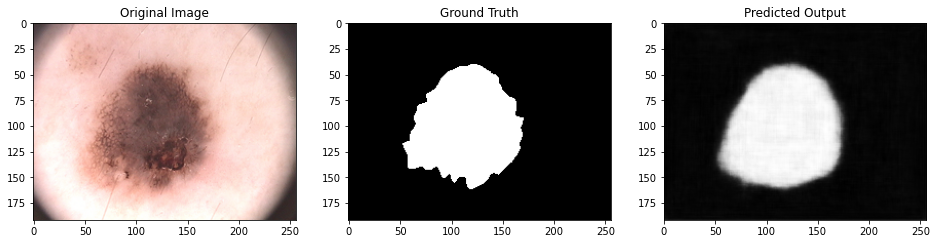

In [47]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 417ms/step


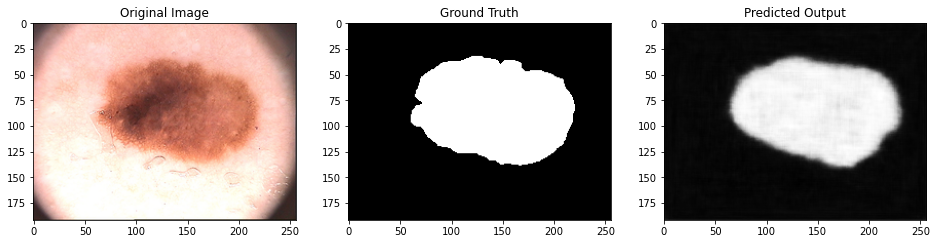

In [48]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

### Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.2 .
* While rounding down the pixel values to 0 which are < 0.2.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values

In [49]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.2:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 0s 451ms/step


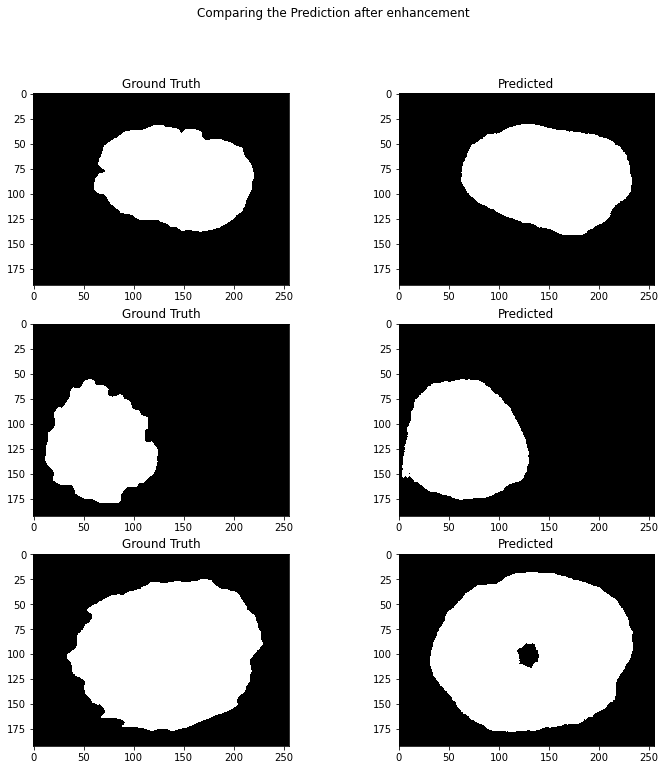

In [50]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[19],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[19]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

So we can observe that our results are very good on the Test dataset which suggests that the model is quite robust and well performing too